# Predicting New York Times "Editor's Selection" comments using NLP and Gradient Boosting

### Overview

The following notebook has the goal to predict the "Editor's Selection" comments of the open articles from the [New York Times](https://www.nytimes.com/) webpage.

The imported dataset contains data from January 2017 until May 2017 and from January 2018 until May 2018, related to articles and comments from NY Times. After importing, some features are pre-selected. The columns are treated and some new features are created. The **editorsSelection** represents if the comment is an "Editor's Selection" or not, and is the *target*.

The feature **commentBody** represents the comment itself. I separated it and processed the text using **NLP** technique **Bag-of-words**.

For the classification, the **Gradient Boosting** Machine Learning algorithm is compared with **SVM** and **Naive Bayes** and tunned with **Grid Search**. Three measures are analyzed: **Accuracy, AUROC, and F1-Score**.

Finally, the results are discussed, and some future works are recommended.

>Some codes and ideas were inspired by [Aashita Kesarwani Predicting NYT's pick notebook](https://www.kaggle.com/aashita/predicting-nyt-s-pick/notebook)

## Table of Contents
- [Importing data](#importing)
- [Feature Engineering](#feature_engineering)
	- [Treating comments](#fe_comments_treatment)
    	- [Removing tags](#fe_ct_removing_tags)
    	- [Removing wrong encoding](#fe_ct_removing_encoding)
    	- [NER](#fe_ct_ner)
    	- [Removing punctuation](#fe_ct_punctuation)
    	- [Treating English words](#fe_ct_english)
	- [Creating new features](#fe_new_features)
    	- [Quantifying categorical features](#fe_nf_categorical)
        - [Normalizing numerical features](#fe_nf_normalizing)
	- [NLP - Bag-of-words](#fe_nlp)
    	- [Count Vectorizer](#fe_nlp_count)
    	- [TF-IDF](#fe_nlp_tf)
- [Modeling and evaluating](#model)
    - [SVM](#model_svm)
    - [Gradient Boost](#model_gradient)
    - [Naive Bayes](#model_naive)
    - [Grid Search](#model_grid)
- [Discussion](#discussion)

## Importing data <a name="importing"></a>

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
import re, string
import time
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline


%matplotlib inline

There are two kinds of datasets: Articles Dataset and Comments Dataset.

The Articles dataset contains more than 9000 articles and 16 features. It represents the articles headers, with information like date of publication (pubDate) and category (newDesk).

The Comments dataset contains more than 2 million comments and 34 features. This dataset includes the comment feature (commentBody) and some information about the comment, i.e. comment date of publication (approveDate). Also, it contains the target feature: **editorsSelection**.

For now, some features will be *excluded* from our study. Some will be removed due to their nature of non-relation with our problem.

Here are the chosen features for now:

|	Articles		|	Comments	|
|---------------------------|---------------------------|
|	articleID				|	articleID				|
|	articleWordCount		|	createDate				|
|	newDesk					|	approveDate				|
|	typeOfMaterial			|	commentBody				|
|	pubDate 				|	recommendations			|
|	     -					|	replyCount				|
|		-					|	editorsSelection		|

In [2]:
art_columns = ['articleID', 'articleWordCount', 'newDesk', 'typeOfMaterial', 'pubDate']
com_columns = ['articleID', 'createDate', 'approveDate', 'commentBody', 'recommendations', 'replyCount','editorsSelection']

df_art_jan17 = pd.read_csv('nyt-comments/ArticlesJan2017.csv', usecols=art_columns)
df_com_jan17 = pd.read_csv('nyt-comments/CommentsJan2017.csv', usecols=com_columns)
df_art_fev17 = pd.read_csv('nyt-comments/ArticlesFeb2017.csv', usecols=art_columns)
df_com_fev17 = pd.read_csv('nyt-comments/CommentsFeb2017.csv', usecols=com_columns)
df_art_mar17 = pd.read_csv('nyt-comments/ArticlesMarch2017.csv', usecols=art_columns)
df_com_mar17 = pd.read_csv('nyt-comments/CommentsMarch2017.csv', usecols=com_columns)
df_art_apr17 = pd.read_csv('nyt-comments/ArticlesApril2017.csv', usecols=art_columns)
df_com_apr17 = pd.read_csv('nyt-comments/CommentsApril2017.csv', usecols=com_columns)
df_art_may17 = pd.read_csv('nyt-comments/ArticlesMay2017.csv', usecols=art_columns)
df_com_may17 = pd.read_csv('nyt-comments/CommentsMay2017.csv', usecols=com_columns)
df_art_jan18 = pd.read_csv('nyt-comments/ArticlesJan2018.csv', usecols=art_columns)
df_com_jan18 = pd.read_csv('nyt-comments/CommentsJan2018.csv', usecols=com_columns)
df_art_fev18 = pd.read_csv('nyt-comments/ArticlesFeb2018.csv', usecols=art_columns)
df_com_fev18 = pd.read_csv('nyt-comments/CommentsFeb2018.csv', usecols=com_columns)
df_art_mar18 = pd.read_csv('nyt-comments/ArticlesMarch2018.csv', usecols=art_columns)
df_com_mar18 = pd.read_csv('nyt-comments/CommentsMarch2018.csv', usecols=com_columns)
df_art_apr18 = pd.read_csv('nyt-comments/ArticlesApril2018.csv', usecols=art_columns)
df_com_apr18 = pd.read_csv('nyt-comments/CommentsApril2018.csv', usecols=com_columns)

comments = [df_com_jan17, df_com_fev17, df_com_mar17, df_com_apr17, df_com_may17, df_com_jan18, df_com_fev18, df_com_mar18, df_com_apr18]
df_comments = pd.concat(comments,sort=False)
articles = [df_art_jan17, df_art_fev17, df_art_mar17, df_art_apr17, df_art_may17, df_art_jan18, df_art_fev18, df_art_mar18, df_art_apr18]
df_articles = pd.concat(articles,sort=False)

df = pd.merge(df_articles, df_comments, on='articleID', how='inner',sort=False)

## Feature Engineering <a name="feature_engineering"></a>

### Treating comments <a name="fe_comments_treatment"></a>

Most of the comments of NY Times naturally are written in English. However, since the comments are opened for anyone, consequently we expect to find errors and unsupported characters (from different languages). For example, HTML tags and Japanese characters.

Since the nature of an "Editor's Selection" comment is to be well written and containing a relevant opinion about the subject, we must treat the inconveniences of the **commentBody** feature.

#### Removing tags <a name="fe_ct_removing_tags"></a>

In [3]:
def remove_tags(text):
    TAG_RE = re.compile(r'<[^>]+>')
    return TAG_RE.sub('', text)

In [4]:
df.commentBody = df.commentBody.apply(remove_tags)

#### Removing wrong encoding <a name="fe_ct_removing_encoding"></a>

In [5]:
%%time
df.commentBody = df.commentBody.apply(lambda x: str(x.encode('ascii', 'ignore')))

CPU times: user 6.65 s, sys: 1.55 s, total: 8.2 s
Wall time: 8.32 s


#### NER <a name="fe_ct_ner"></a>

Using Name Entity Recognition (NER) and some English dictionary, it is possible to maintain only English words in comments.

In [6]:
#Creating Name/Entity/Place dictionary
def NER(sr):
    continuous_chunk = []
    for row in sr:
        chunked = ne_chunk(pos_tag(word_tokenize(row)))
        prev = None
        current_chunk = []
        for i in chunked:
            if type(i) == Tree:
                current_chunk.append(" ".join([token for token, pos in i.leaves()]))
            elif current_chunk:
                named_entity = " ".join(current_chunk)
                continuous_chunk.append(named_entity)
                current_chunk = []
    return set(continuous_chunk)

In [7]:
%%time
#Using only NER extracted from comments selected as "Editor's Selection" to reduce the dictionary
people_words = NER(df[df['editorsSelection'] == 1].commentBody)

CPU times: user 22min 37s, sys: 4.42 s, total: 22min 41s
Wall time: 22min 46s


In [8]:
#Creating English Dictionary using NLTK package
words = set(nltk.corpus.words.words() + list(nltk.corpus.wordnet.words()) + list(people_words))

#### Removing punctuation <a name="fe_ct_punctuation"></a>

In [9]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]',' ',text)

In [10]:
df.commentBody = df.commentBody.apply(remove_punctuation)

#### Treating English words <a name="fe_ct_english"></a>

In [11]:
def clean_text(text):
    return " ".join(w for w in nltk.wordpunct_tokenize(text) if w in words or w.lower() in words or (nltk.corpus.wordnet.morphy(w.lower()) is not None and nltk.corpus.wordnet.morphy(w.lower()).lower() in words))


In [12]:
%%time
df.commentBody = df.commentBody.apply(clean_text)

CPU times: user 3min 47s, sys: 635 ms, total: 3min 47s
Wall time: 3min 47s


### Creating new features <a name="fe_new_features"></a>

The data features won't be useful in their original conditions. It is necessary to quantify them.

In this case, it will be created two new features: **commentApprovalLength**, which represents the waiting time for the comment to be approved; and **commentPubLength**, which is the time between the article publication and the comment publication.

In [13]:
df['commentApprovalLength'] = df.apply(lambda row: (dt.datetime.fromtimestamp(int(row['approveDate'])) - dt.datetime.fromtimestamp(int(row['createDate']))).total_seconds(), axis=1)
df['commentPubLength'] = df.apply(lambda row: (dt.datetime.fromtimestamp(int(row['approveDate'])) - dt.datetime.strptime(row['pubDate'], '%Y-%m-%d %H:%M:%S')).total_seconds(), axis=1)

Also, it is now possible to count the number of words of the treated commentBody feature creating a new column called **commentWordCount**.

In [14]:
df['commentWordCount'] = df.apply(lambda row: sum(Counter(row['commentBody'].split()).values()), axis=1)

In [15]:
#Cleaning unused features
df.drop(columns=['approveDate', 'createDate', 'articleID', 'pubDate'], inplace=True)

#### Quantifying categorical features <a name="fe_nf_categorical"></a>

The categorical features should be transformed into numerical features to help the classifier to not misinterpret. It will be created new columns to represent the categories in numbers (0 or 1).

In [16]:
df = pd.get_dummies(df, columns=["newDesk", "typeOfMaterial"])

#### Normalizing numerical features <a name="fe_nf_normalizing"></a>

The numerical features should be normalized to avoid wrong weighted classification. The MinMaxScaler() will be used for that.

In [17]:
min_max_scaler = preprocessing.MinMaxScaler()
#Array with numerical features
np_numbers = df[['articleWordCount', 'recommendations', 'replyCount', 'commentWordCount', 'commentApprovalLength', 'commentPubLength']].values.astype(float)

#Normalizing
np_scaled = min_max_scaler.fit_transform(np_numbers)
df_normalized = pd.DataFrame(np_scaled)
#Renaming columns
df_normalized.columns = ['articleWordCount', 'recommendations', 'replyCount', 'commentWordCount', 'commentApprovalLength', 'commentPubLength']

#Joining new dataframe
cols = [i for i in df.columns.values if i not in list(['articleWordCount', 'recommendations', 'replyCount', 'commentWordCount','commentApprovalLength','commentPubLength'])]
df_normalized = df_normalized.join(df[cols])

In [18]:
#Checking how the features are now
df_normalized.head(2)

,articleWordCount,recommendations,replyCount,commentWordCount,commentApprovalLength,commentPubLength,commentBody,editorsSelection,newDesk_Arts&Leisure,newDesk_Automobiles,...,typeOfMaterial_Editorial,typeOfMaterial_Interview,typeOfMaterial_Letter,typeOfMaterial_News,typeOfMaterial_News Analysis,typeOfMaterial_Obituary (Obit),typeOfMaterial_Op-Ed,typeOfMaterial_Question,typeOfMaterial_Review,typeOfMaterial_briefing
0,0.080429,0.000477,0.160804,0.296117,0.001731,0.005408,b For all you Americans out there still rejoic...,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0.080429,0.000286,0.160804,0.145631,0.002221,0.005402,b Obamas policies may prove to be the least of...,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Balancing classes <a name="fe_balancing"></a>

Let's check how the targed feature **editorsSelection** is balanced in the sample.

editorsSelection(1): 1.9107573251608228%


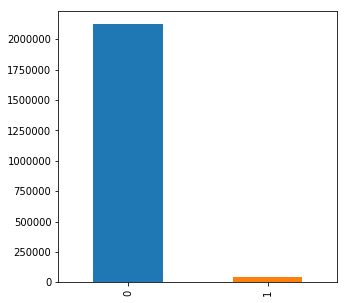

In [19]:
pd.value_counts(df_normalized['editorsSelection']).plot.bar(figsize = (5,5))
print("editorsSelection(1): " + str((float(pd.value_counts(df_normalized['editorsSelection'])[1])/float(pd.value_counts(df_normalized['editorsSelection']).sum())) * 100) + "%")

It is notable the unbalanced dataset. The editorsSelection class = 1 represents **1.91%** of the entire dataset. To work with this class, it is necessary to downsample the editorsSelection class = 0.

In [20]:
'''
Returns the balanced class using the percentage that is needed to maintain in the class with less occurrence.
For example, if we need the class 1 (minority) to represents 30% of the entire dataset, percent = 0.3. 
The class 0 (majority) will have samples removed randomly until it represents 70% of the entire dataset.
'''
def downSampling(sample, col_class, percent):
    #Finding the majority and minority class
    counts = sample[col_class].value_counts().to_dict()
    max_label = max(counts.keys(), key=(lambda k: counts[k]))
    min_label = min(counts.keys(), key=(lambda k: counts[k]))
    #Separating class samples
    sample_max = sample[sample[col_class] == max_label]
    sample_min = sample[sample[col_class] == min_label]
    #Finding the actual ratio between classes
    actual_ratio = float(min(counts.values()))/float(sum(counts.values()))
    if(actual_ratio >= percent):
        return sample
    #Calculating the number of necessary samples to be excluded
    desired_samples = int(float(min(counts.values()) - (percent * min(counts.values()))) / float(percent))
    #Resampling dataset
    sample_max_downsampled = resample(sample_max, replace=False, n_samples=desired_samples, random_state=100)
    #Combining samples
    sample_downsampled = pd.concat([sample_max_downsampled, sample_min])
    return sample_downsampled

#It was chosen the 1:4 (25%) ratio for downsampling
df_normalized_balanced = downSampling(df_normalized, 'editorsSelection', 0.25)

editorsSelection(1): 25.0%


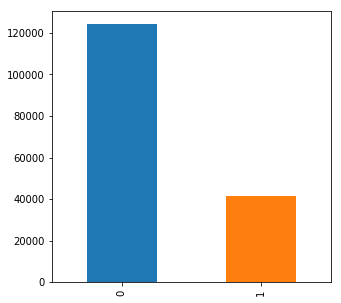

In [21]:
pd.value_counts(df_normalized_balanced['editorsSelection']).plot.bar(figsize = (5,5))
print("editorsSelection(1): " + str((float(pd.value_counts(df_normalized_balanced['editorsSelection'])[1])/float(pd.value_counts(df_normalized_balanced['editorsSelection']).sum())) * 100)+ "%")

>It was chosen the value of 25% to compare to [Aashita Kesarwani Predicting NYT's pick notebook](https://www.kaggle.com/aashita/predicting-nyt-s-pick/notebook)

Now the editorsSelection class = 1 is balanced to represents **25%** of the dataset.

### NLP - Bag-of-words <a name="fe_nlp"></a>

To transform the comments texts in features, the **NLP** technique **Bag-of-words** is implemented in the *commentBody* column.

#### Count Vectorizer <a name="fe_nlp_count"></a>

The Count Vectorizer transform text into a count vector of words.

In [7]:
%%time
count_vec = CountVectorizer(stop_words='english', ngram_range=(1,1))
counts = count_vec.fit_transform(df_normalized_balanced['commentBody'].values.astype('U'))

print(counts.shape)

(165944, 60959)
CPU times: user 9.81 s, sys: 1.01 s, total: 10.8 s
Wall time: 11.5 s


#### TF-IDF <a name="fe_nlp_tf"></a>
To reduce the weight of the counting, it is needed to normalize frequency with TF-IDF.

In [8]:
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(counts)

print(tfidf.shape)

(165944, 60959)


**What we have so far**: cleaned and treated features, extra features and comment texts vectorized.

Now we build our model.

## Modeling and evaluating <a name="model"></a>

Firstly, let's separate the target feature from the rest.

In [9]:
y = df_normalized_balanced[['editorsSelection']]
X = df_normalized_balanced.drop(['editorsSelection', 'commentBody'], axis=1)

The classification algorithm chosen is SVM with linear kernel (**SGDClassifier**).

The chosen metrics to measure the model performance will be **Accuracy**, **AUROC**, and **F1-Score**.

- Accuracy will measure the overall performance of the model
- Area Under ROC Curve (AUROC) checks the model's consistency comparing the true-positive rate against the false-positive rate 
- F1-Score also validates the unbalanced classes due to the true-positive rate and false-positive rate. It shows how well the model is generalising the predicting.

For training and validation, the dataset will be split into three parts: **80%/20%**, **70%/30%** e **60%/40%** (Training/Testing). After that, we calculate the mean of the metrics.

In [10]:
def get_metrics(y_test, predicted):
    fpr, tpr, thresholds = roc_curve(y_test, predicted, pos_label=1)
    roc = auc(fpr, tpr)
    f1 = f1_score(y_test, predicted, average='binary')
    ac = np.mean(predicted == y_test)
    return roc, f1, ac

In [11]:
def train_predict(clf, X_train, y_train, X_test):
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    return predicted

def results_train_test(clf, X, y):

    X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
    X_train_60, X_test_40, y_train_60, y_test_40 = train_test_split(X, y, stratify=y, test_size=0.4, random_state=42)

    pred_20 = train_predict(clf, X_train_80, y_train_80, X_test_20)
    pred_30 = train_predict(clf, X_train_70, y_train_70, X_test_30)
    pred_40 = train_predict(clf, X_train_60, y_train_60, X_test_40)

    roc20, f120, acc20 = get_metrics(y_test_20, pred_20)
    roc30, f130, acc30 = get_metrics(y_test_30, pred_30)
    roc40, f140, acc40 = get_metrics(y_test_40, pred_40)
    mean_roc = (roc20 + roc30 + roc40) / 3
    mean_acc = (acc20 + acc30 + acc40) / 3
    mean_f1 = (f120 + f130 + f140) / 3
    print('Mean Accuracy: {0:0.2f}'.format(mean_acc))
    print('Mean AUROC: {0:0.2f}'.format(mean_roc))
    print('Mean F1-Score: {0:0.2f}'.format(mean_f1))

Now create the full feature vector, joining the TF-IDF output and the others features.

>Hstack is used to avoid memory overflow when adding the TF-IDF features to dataframe. Also, we will work with sparse matrices from now on.

In [12]:
cols = [i for i in df_normalized_balanced.columns.values if i not in list(['editorsSelection','commentBody', 'articleWordCount'])]

features_vector = hstack((tfidf,np.array(X['articleWordCount'])[:,None]))
for i in cols:
    features_vector = hstack((features_vector,np.array(X[i])[:,None]))
print(features_vector.shape)

(165944, 61023)


The dataset is ready for the supervised learning testing.

These three algorithm will be tested:
- SGDClassifier (loss = 'hinge' means SVM with Linear Kernel)
- XGBoost (Gradient Boost)
- MultinomialNB (Naive Bayes)

### SVM <a name="model_svm"></a>

In [28]:
#Creating SVM class with arbitrary parameters
svm_clf = linear_model.SGDClassifier(loss='hinge', max_iter=20, tol=1e-3, random_state=42)

In [29]:
%%time
results_train_test(svm_clf, features_vector, y.values.ravel())

Mean Accuracy: 0.80
Mean AUROC: 0.61
Mean F1-Score: 0.35
CPU times: user 2.43 s, sys: 252 ms, total: 2.68 s
Wall time: 2.34 s


### Gradient Boosting <a name="model_gradient"></a>

In [30]:
xgb_clf = xgb.XGBClassifier(random_state=42)

In [31]:
%%time
results_train_test(xgb_clf, features_vector, y.values.ravel())

Mean Accuracy: 0.91
Mean AUROC: 0.86
Mean F1-Score: 0.81
CPU times: user 2min 39s, sys: 553 ms, total: 2min 40s
Wall time: 2min 40s


### Naive Bayes <a name="model_naive"></a>

In [33]:
nb_clf = MultinomialNB(alpha = 0.1)

In [34]:
%%time
results_train_test(nb_clf, features_vector, y.values.ravel())

Mean Accuracy: 0.76
Mean AUROC: 0.55
Mean F1-Score: 0.23
CPU times: user 1.39 s, sys: 353 ms, total: 1.74 s
Wall time: 1.91 s


Comparing the results, the Gradient boosting **XGBoost** classifier performed better than **SVM** with linear kernel and **Naive Bayes**.

To optimise the **XGBoost** performance, **Grid Search** will choose the best parameters.

### Grid Search <a name="model_grid"></a>

In [24]:
#Some parameters to grid search
cv_params = {
    'max_depth': [8, 9, 10], 
    'min_child_weight': [6, 7, 8],
    'learning_rate': [0.1, 0.2]
            }
#Some default parameters
ind_params = {
    'nthread': 4,
    'n_estimators': 100, 
    'seed':0, 
    'subsample': 0.8, 
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic'
            }

Since the unbalanced dataset is present, using the Grid Search for tunning the *f1-Score* is a good choice.

In [25]:
grid = GridSearchCV(xgb.XGBClassifier(**ind_params),
                            cv_params,
                             scoring = 'f1', cv = 5, n_jobs = -1)

In [26]:
%%time
grid.fit(features_vector, y.values.ravel())

CPU times: user 3min 33s, sys: 741 ms, total: 3min 33s
Wall time: 1h 19min 9s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [8, 9, 10], 'min_child_weight': [6, 7, 8], 'learning_rate': [0.1, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [27]:
print("Best Parameters:")
best_parameters = grid.best_estimator_.get_params()
for param_name in sorted(cv_params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best Parameters:
	learning_rate: 0.1
	max_depth: 8
	min_child_weight: 7


In [28]:
best_parameters.update(ind_params)
print(best_parameters)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 7, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': True, 'subsample': 0.8}


With the best parameters, it is possible to improve XGBoost performance.

In [29]:
xgb_optm_clf = xgb.XGBClassifier(**best_parameters)

In [30]:
results_train_test(xgb_optm_clf, features_vector, y.values.ravel())

Mean Accuracy: 0.91
Mean AUROC: 0.87
Mean F1-Score: 0.82


## Discussion <a name="discussion"></a>

The XGBoost results:

|Raw|-			|
|-|-----------------------|
| Mean Accuracy			| 0.91 |
| Mean AUROC  | 0.86 |
| Mean F1-Score			| 0.81 |

|Grid Search |	-			|
|-|-----------------------|
| Mean Accuracy| 0.91 |
| Mean AUROC  | 0.87 |
| Mean F1-Score			| 0.82 |

The results now are way slightly better after Grid searching some parameters. Improving the f1-score in Grid Search helped the XGBoost to penalize misclassification of the class = 1.

When dealing with such unbalanced dataset, the F1-Score is the appropriate measurement to see how the model handles overfitting. The value of 0.82 of F1-Score is good and *acceptable* to use in a production level since the **New York Times** need to look at most comments to make a good choice. If the model is used, it's possible to **reduce** the number of analyzed comments and optimize the editor's work. Also, it can be used to automatize the editor's choice.

#### Future work suggestions

There are some ways to improve the model.

- The ignored features from the beginning may be used to achieve new insights into the dataset.
- Feature selection may help to improve the model generalisation and avoid overfitting.